### Bank Marketing Campaign Success Prediction
https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets

#### Task 
- This project aims to use various characteristics of clients in a Bank Marketing dataset to predict if the client subscribed to the term deposit. I will use this data to build a surpervised ML binary classification model to predict marketing success using Logistic Regression, Random Forest and XGBoost

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
# xgboost
from xgboost import XGBClassifier

## Data Exploration & Visualization

In [5]:
#importing dataset
df = pd.read_csv('train.csv', sep=';')

In [6]:
# check the shape of the data: row: 45211 samples, column: 17 attributes
df.shape

(45211, 17)

In [7]:
# example rows of the dataset
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


There are 16 features, which includes 9 categorical and 7 numerical features

In [8]:
# overview of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


#### Here are the descriptions of attributes, adopted from https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets
- age (numeric)
- job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                    "blue-collar","self-employed","retired","technician","services")
- marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
- education (categorical: "unknown","secondary","primary","tertiary")
- default: has credit in default? (binary: "yes","no")
- balance: average yearly balance, in euros (numeric)
- housing: has housing loan? (binary: "yes","no")
- loan: has personal loan? (binary: "yes","no")
##### related with the last contact of the current campaign:
- contact: contact communication type (categorical: "unknown","telephone","cellular")
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
- duration: last contact duration, in seconds (numeric)
##### other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
##### Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: "yes","no")

In [9]:
numerical_col = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
categorical_col = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                   'contact', 'poutcome']
date_col = ['day', 'month']

In [10]:
#check if null exists
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### check class distribution
There are 39922 samples in class 0 (no) and 5289 in class 1（yes), which is very imbalanced

In [11]:
# check the distribution of the target variable
df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [12]:
df['y'].value_counts(normalize=True)

no     0.883015
yes    0.116985
Name: y, dtype: float64

<AxesSubplot: >

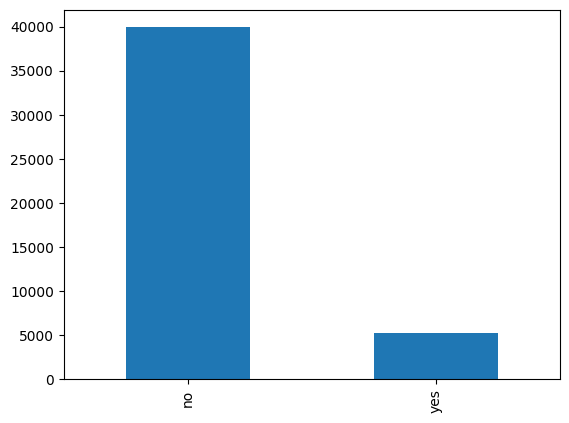

In [13]:
df['y'].value_counts().plot(kind='bar')

#### check multi-collinearity
- no multicollinearity was found between all numerical variables

C:\Users\jessi\AppData\Local\Temp\ipykernel_58076\120653903.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

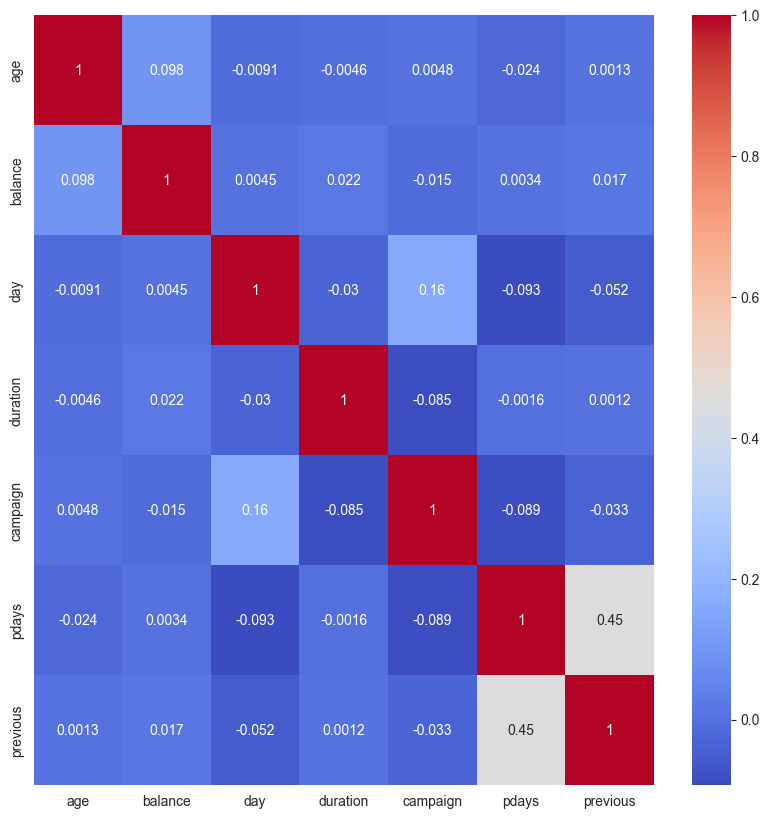

In [150]:
# check for multicollinearity
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')


#### Visualize the Data

- ##### Visualize distribution of numerical data: 
we can see that the distribution of numerical variables are not normal, most of them are skewed with tail on the right side, this means that majority of customers were not contacted before, or the last effort was not significant; Thus, I will remove outliers before modeling.

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'balance'}>,
        <AxesSubplot: title={'center': 'day'}>],
       [<AxesSubplot: title={'center': 'duration'}>,
        <AxesSubplot: title={'center': 'campaign'}>,
        <AxesSubplot: title={'center': 'pdays'}>],
       [<AxesSubplot: title={'center': 'previous'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

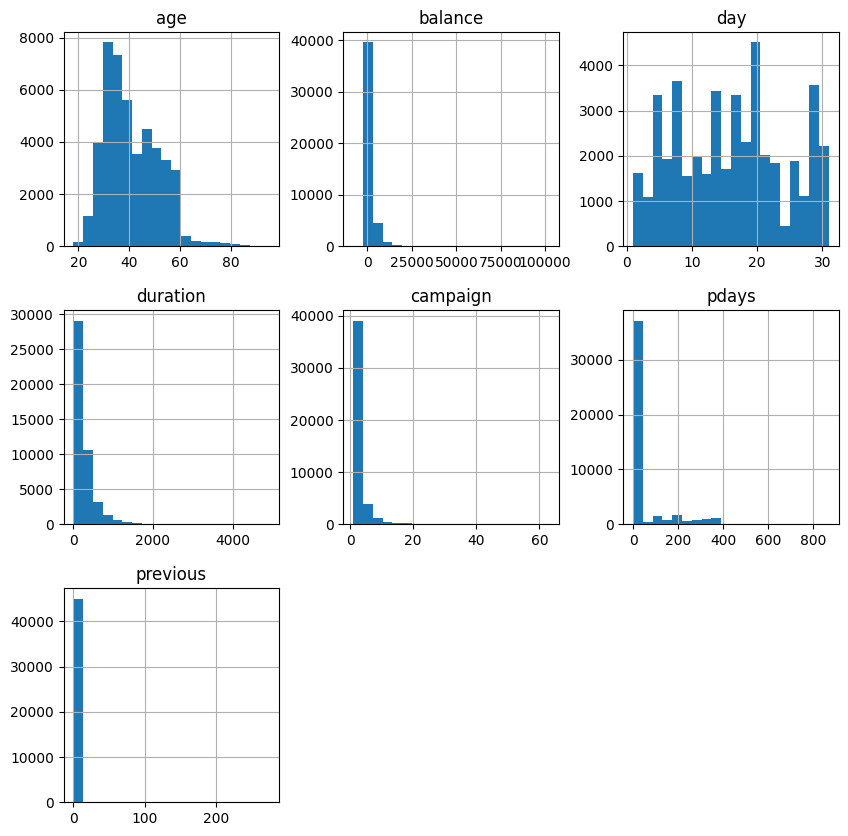

In [15]:
# visualize the distribution of numerical variables
df.hist(figsize=(10,10), bins=20)

- ##### Visualize frequency of target value for categororical variables: 
we can see that bank contacted more customers with stable jobs like management than people who are retired, unemployed or are students.They also contacted more married person, people with higher education 
It's also interesting to see that banks contacted more people w/ housing loans, but those without loans subscribed more; likewise, people without loans were contacted more and subscribed more.

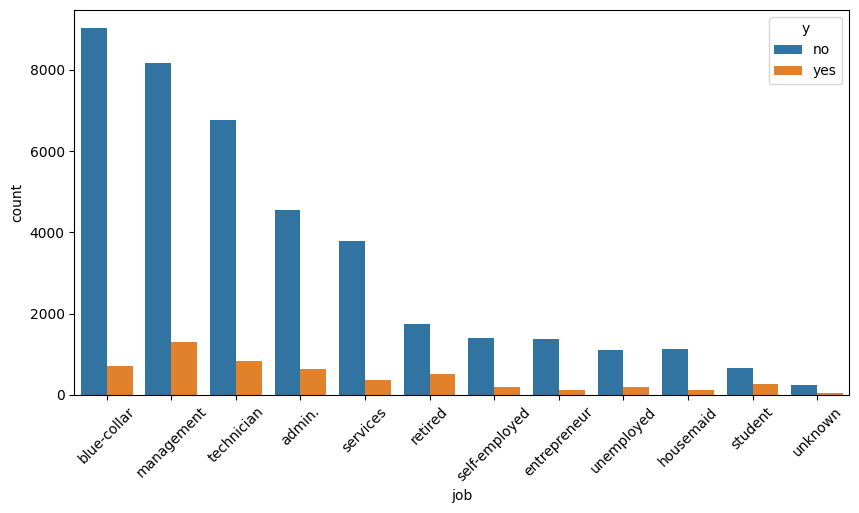

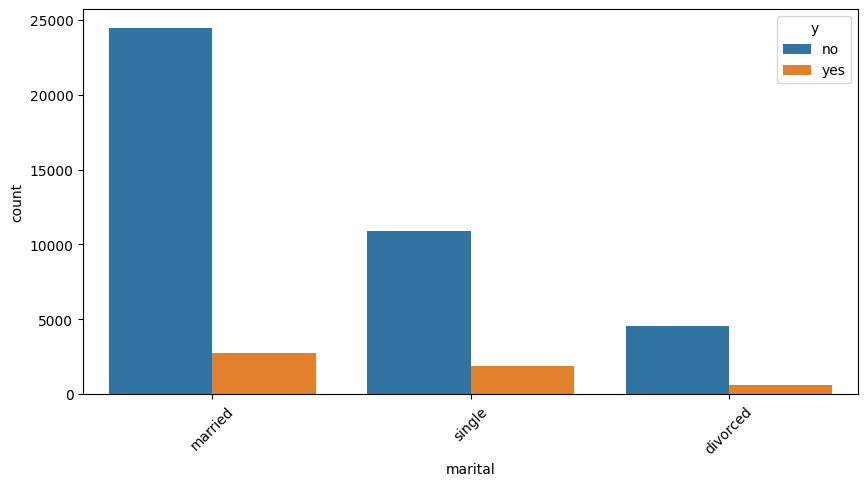

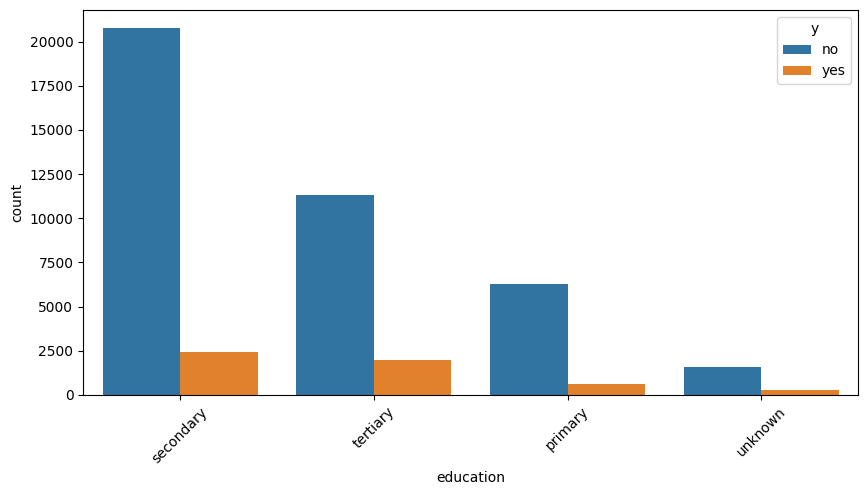

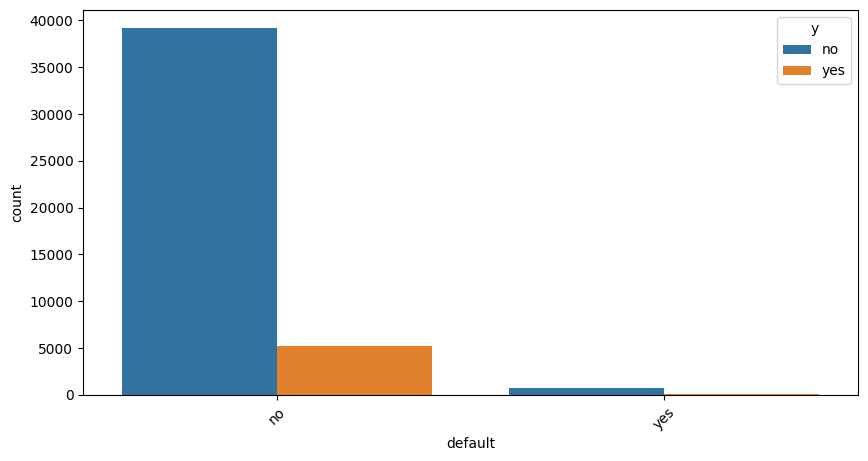

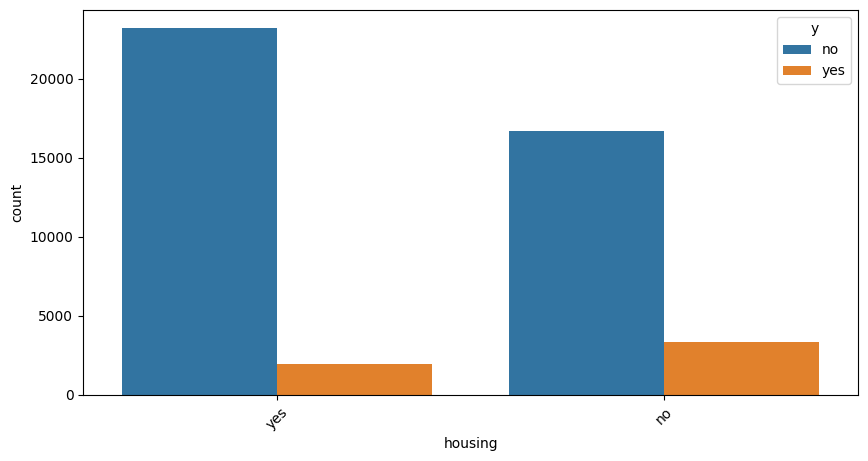

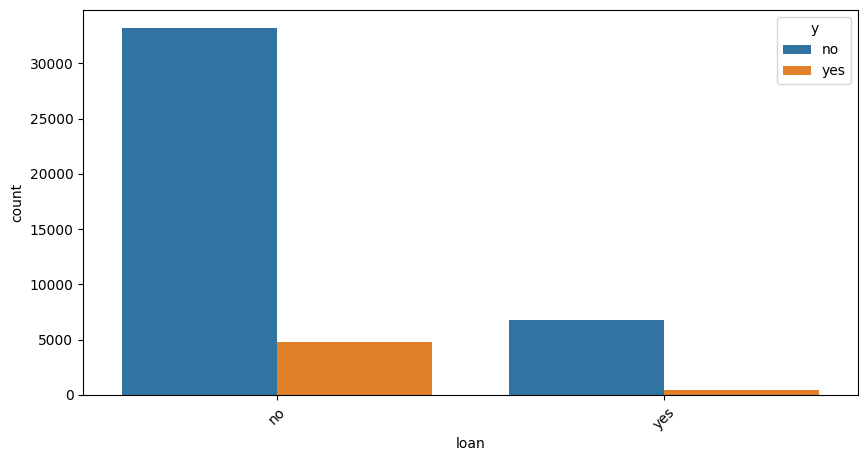

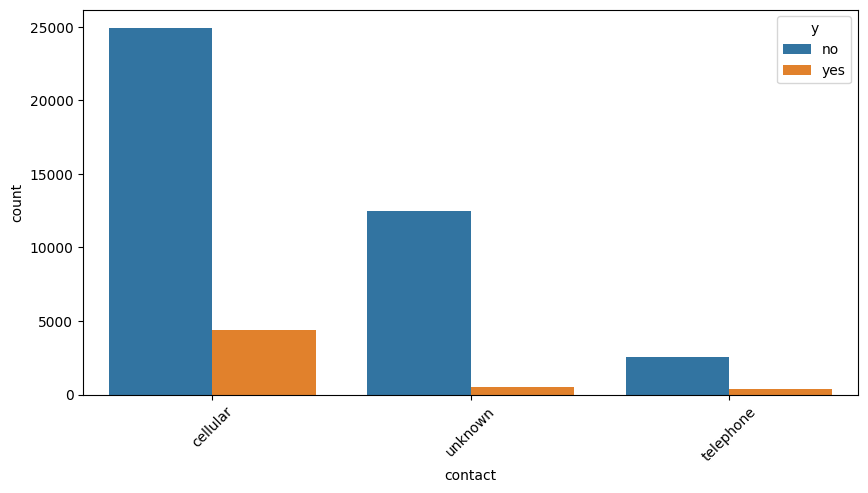

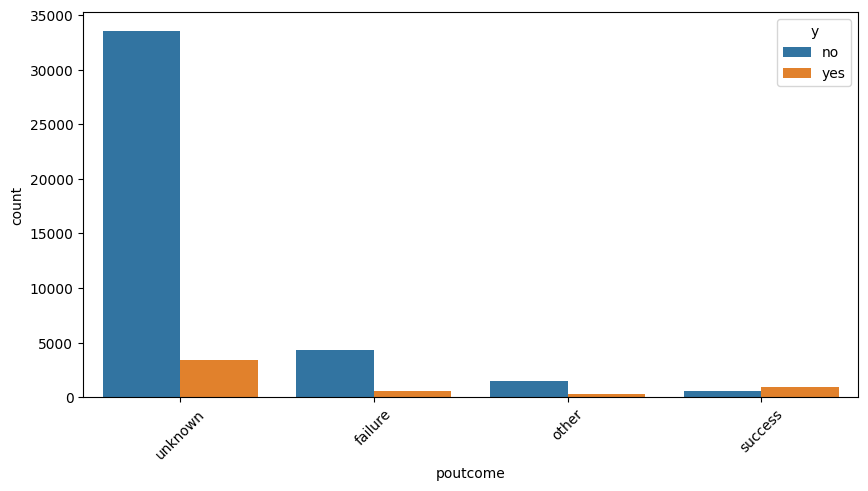

In [16]:
# Visualize frequency of target value for categororical variables
for col in categorical_col:
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, hue='y', data=df, order = df[col].value_counts().index)
    plt.xticks(rotation=45)

#### Data Preparation
1. remove outliers and "unknowns"
2. Feature Engineering 

- ##### Check "unknowns"

In [17]:
# check the features with "unknown" values
df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [18]:
df['education'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [19]:
df['contact'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [20]:
# Because 'unknown' values are not very large in job and education, we can replace them with the most frequent value
df['job'].replace('unknown', 'blue-collar', inplace=True)
df['education'].replace('unknown', 'secondary', inplace=True)
# Because 'unknown' values are very large in contact, we will not do anything with them since the amount might be informative

- ##### Check outliers

In [21]:
df[numerical_col].describe()

,age,balance,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [22]:
# according to the description, we can see that balance, duration, campaign, pdays, previous have outliers
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1
lower_thresh = Q1 - 1.5*IQR
upper_thresh = Q3 + 1.5*IQR
Q1, Q3, lower_thresh, upper_thresh

(72.0, 1428.0, -1962.0, 3462.0)

In [23]:
# remove outliers
df = df[(df['balance'] > lower_thresh) & (df['balance'] < upper_thresh)]

<AxesSubplot: xlabel='balance'>

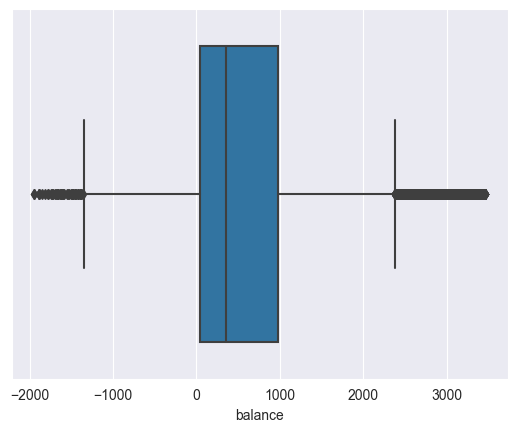

In [24]:
#check current distribution
sns.set_style("darkgrid",{'axes.grid' : True})
sns.boxplot(x=df['balance'], orient='h')

In [25]:
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)
IQR = Q3 - Q1
lower_thresh = Q1 - 1.5*IQR
upper_thresh = Q3 + 1.5*IQR
Q1, Q3, lower_thresh, upper_thresh

(103.0, 316.0, -216.5, 635.5)

In [26]:
df = df[(df['duration'] > lower_thresh) & (df['duration'] < upper_thresh)]

<AxesSubplot: xlabel='duration'>

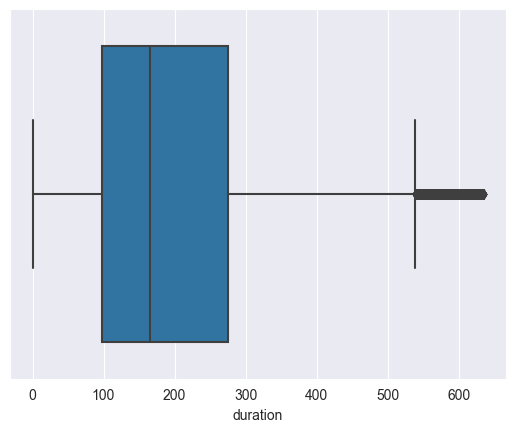

In [27]:
sns.boxplot(x=df['duration'], orient='h')

In [28]:
Q1 = df['campaign'].quantile(0.25)
Q3 = df['campaign'].quantile(0.75)
IQR = Q3 - Q1
lower_thresh = Q1 - 1.5*IQR
upper_thresh = Q3 + 1.5*IQR
Q1, Q3, lower_thresh, upper_thresh

(1.0, 3.0, -2.0, 6.0)

In [29]:
df = df[(df['campaign'] > lower_thresh) & (df['campaign'] < upper_thresh)]

<AxesSubplot: xlabel='campaign'>

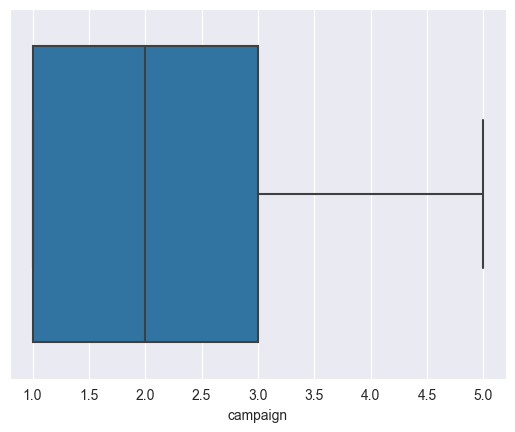

In [30]:
sns.boxplot(x=df['campaign'], orient='h')

In [31]:
Q1 = df['pdays'].quantile(0.25)
Q3 = df['pdays'].quantile(0.75)
IQR = Q3 - Q1
lower_thresh = Q1 - 1.5*IQR
upper_thresh = Q3 + 1.5*IQR
Q1, Q3, lower_thresh, upper_thresh

(-1.0, -1.0, -1.0, -1.0)

In [32]:
df = df[(df['pdays'] == -1.0)]

<AxesSubplot: xlabel='pdays'>

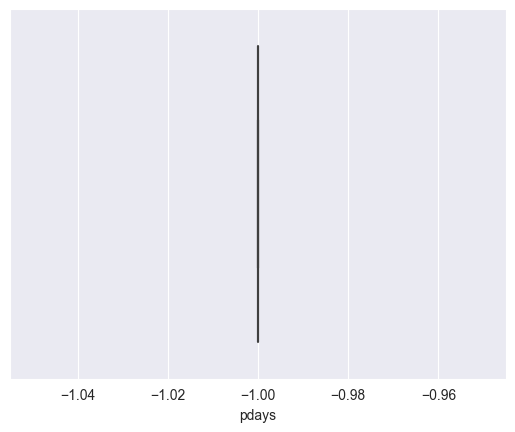

In [33]:
sns.boxplot(x=df['pdays'], orient='h')

In [34]:
Q1 = df['previous'].quantile(0.25)
Q3 = df['previous'].quantile(0.75)
IQR = Q3 - Q1
lower_thresh = Q1 - 1.5*IQR
upper_thresh = Q3 + 1.5*IQR
Q1, Q3, lower_thresh, upper_thresh

(0.0, 0.0, 0.0, 0.0)

In [35]:
df['previous'].describe()

count    27405.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: previous, dtype: float64

<AxesSubplot: xlabel='previous'>

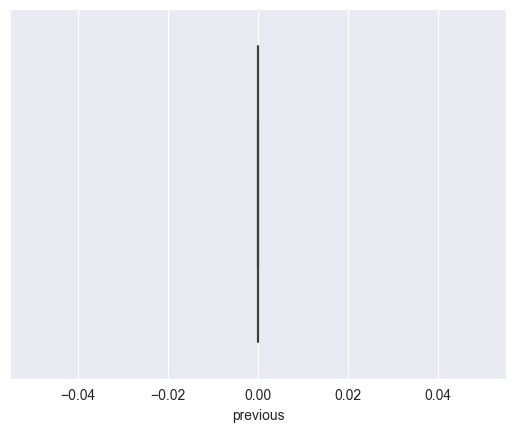

In [36]:
sns.boxplot(x=df['previous'], orient='h')

- #### Encode Categorical Variables

In [37]:
#encode categorical variables as 0 and 1 for features with 'yes' and 'no' values
df['default'] = df['default'].map({'no':0, 'yes':1})
df['housing'] = df['housing'].map({'no':0, 'yes':1})
df['loan'] = df['loan'].map({'no':0, 'yes':1})

# encode target variable as 0 and 1
df['y'] = df['y'].map({'no':0, 'yes':1})

In [38]:
# one hot encode categorical variables with more than 2 values
cols = ['job', 'marital', 'contact', 'poutcome', 'month']
df = pd.get_dummies(df, columns=cols, drop_first=True, dtype=int)

In [39]:
# label encode education because it's ordinal data
df['education'] = df['education'].map({'primary':0, 'secondary':1, 'tertiary':2})

- #### normalize numerical variables

In [40]:
# separate x and y
X = df.drop('y', axis = 1)
y = df['y']

In [41]:
# normalize numerical variables
scaler = StandardScaler()
X[numerical_col] = scaler.fit_transform(X[numerical_col])

In [42]:
X[numerical_col].describe()

,age,balance,duration,campaign,pdays,previous
count,2.740500e+04,2.740500e+04,2.740500e+04,2.740500e+04,27405.0,27405.0
mean,6.844856e-17,-5.807757e-17,8.504215e-17,-4.148398e-17,0.0,0.0
std,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,0.0,0.0
min,-2.179237e+00,-3.060706e+00,-1.493749e+00,-9.112672e-01,0.0,0.0
25%,-8.303606e-01,-6.925320e-01,-7.537940e-01,-9.112672e-01,0.0,0.0
50%,-1.559222e-01,-3.499434e-01,-2.604903e-01,-4.967405e-02,0.0,0.0
75%,7.112128e-01,3.819504e-01,5.302465e-01,8.119191e-01,0.0,0.0
max,5.239585e+00,3.413740e+00,3.112836e+00,2.535105e+00,0.0,0.0


In [43]:
# final data shape
X.shape

(27405, 36)

In [44]:
#make all columns int
X = X.astype(int)

In [45]:
# split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19183, 36) (8222, 36) (19183,) (8222,)


#### Deal with Class Imbalance
- The dataset consists of 88.3% class 0 and only 11.7% class 1. This imbalance will decrease the predictive power of ML model, especially on the minority class
- we will use undersampling, oversampling and compare their performances to no resampling at all.

In [46]:
# generate dataset with undersampling
rus = RandomUnderSampler(sampling_strategy='majority',random_state=42)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
print(X_train_us.shape, y_train_us.shape)

(2266, 36) (2266,)


In [47]:
y_train_us.value_counts()

0    1133
1    1133
Name: y, dtype: int64

We can see that datasize significantly decreased to keep proportion the same with minority class. Since the training dataset has much smaller size, I think undersampling method will not produce good model

In [48]:
# generate dataset with oversampling
ros = RandomOverSampler(sampling_strategy='minority',random_state=42)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)
print(X_train_os.shape, y_train_os.shape)


(36100, 36) (36100,)


In [49]:
y_train_os.value_counts()

0    18050
1    18050
Name: y, dtype: int64

we can see that the dataset is much larger than the original dataset because oversampling takes minority class sample and duplicates them to make the dataset balanced

#### Modeling
1. Logistic Regression
2. Random Forest
3. LightGBM
- For each model, I used GridSearchCV to tune hyperparameters and return the best parameter settings and 5-fold cross validate
I chose to use three scoring: 
- Accuracy measures the percentage of correct predictions, which could be misleading when datase is imbalanced
- F1 score takes into account both precision and recall, thus is useful for imbalanced dataset
- ROC-AUC measures if model can distinguish between positive and negative samples. It plots the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds; Thus can also capture class imbalance problem

#### Logistic regression

In [50]:
# train logistic regression model with grid search
def train_logistic(X_train, y_train):
    """
    Train a logistic regression model with grid search
    Input:
        X_train: training data
        y_train: training labels
    Output:
        grid: trained grid search model
    """
    lr = LogisticRegression(random_state=42)
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'], 'solver' : ['liblinear']}
    grid = GridSearchCV(lr, param_grid, cv=5, scoring= ['accuracy','f1', 'roc_auc'], refit='f1')
    grid.fit(X_train, y_train)
    
    return grid

- I chose to use different 'C' values because it is the inverse of regularization strength, which tells model how much to avoid overfitting. A small value of 'C' will force the model to choose simpler coefficients, which may lead to underfitting, while a large value of 'C' will allow the model to choose more complex coefficients, which may lead to overfitting. 
- I also asks the gridsearch to find out which penaity performs better. L1 penalty penalizes the absolute value of the coefficients which also performs feature selection; l2 penalty penalizes the square of the coefficients, which aims to penalize large weights. 
- I chose liblinear solver because it deals with both l1 and l2 penality and converged successfully while saga didn't


In [51]:
# train logistic regression model with original dataset
grid_original = train_logistic(X_train, y_train)
print(grid_original.best_params_)
print(grid_original.best_score_)

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.24796214811578415


In [52]:
grid_original.cv_results_['mean_test_accuracy']

array([0.9409373 , 0.94088517, 0.94088521, 0.94078099, 0.94114602,
       0.94078114, 0.94177159, 0.94182373, 0.94203223, 0.94208437,
       0.94192797, 0.94198011, 0.94192797, 0.94192797])

In [53]:
grid_original.cv_results_['mean_test_f1']

array([0.        , 0.        , 0.01903308, 0.06558532, 0.17622043,
       0.16457213, 0.24004011, 0.23801201, 0.24796215, 0.24717729,
       0.2476028 , 0.24779821, 0.2476028 , 0.2476028 ])

In [153]:
# check model performance on test set
logreg_pred = grid_original.best_estimator_.predict(X_test)
print(accuracy_score(y_test, logreg_pred))
print(classification_report(y_test, logreg_pred))
print(f1_score(y_test, logreg_pred))

0.9407686694234979
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7724
           1       0.54      0.15      0.24       498

    accuracy                           0.94      8222
   macro avg       0.74      0.57      0.60      8222
weighted avg       0.92      0.94      0.92      8222

0.23787167449139282


- The best parameters for original dataset are {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}, but the score is only 0.24
- comparing test accuracy and test f1 from the gridsearch, we can see that the model performs well when not considering precision and recall, which tends to be low when class is imbalanced; this is similar when testing on test dataset


In [55]:
# train logistic regression model with undersampled dataset
grid_us = train_logistic(X_train_us, y_train_us)
print(grid_us.best_params_)
print(grid_us.best_score_)
print(grid_us.cv_results_['mean_test_accuracy'])
print(grid_us.cv_results_['mean_test_f1'])

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.8234416632072203
[0.5        0.74934796 0.66858827 0.79744532 0.81156266 0.82127374
 0.82568875 0.82436522 0.82568875 0.82612928 0.82524822 0.82524822
 0.82524822 0.82524822]
[0.         0.73067643 0.58575172 0.79894734 0.81139282 0.82072804
 0.8222964  0.8214579  0.82303769 0.82344166 0.82249513 0.82249513
 0.82249513 0.82249513]


In [155]:
print(np.mean(grid_us.cv_results_['mean_test_accuracy']))
np.mean(grid_us.cv_results_['mean_test_f1'])

0.7822202031905331


0.7376936093431847

In [156]:
# check model performance on test set
logreg_pred = grid_us.best_estimator_.predict(X_test)
print(accuracy_score(y_test, logreg_pred))
print(f1_score(y_test, logreg_pred))
print(classification_report(y_test, logreg_pred))

0.8119678910240817
0.33931623931623933
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      7724
           1       0.22      0.80      0.34       498

    accuracy                           0.81      8222
   macro avg       0.60      0.81      0.61      8222
weighted avg       0.94      0.81      0.86      8222



- the best parameters are c=0.001, penalty=l2, solver=liblinear, the model scored much higher, especially on f1, which means solving class imbalance problem increased recall
- However, the f1 score on class 1 is still low; and accuracy dropped on testing dataset compared to model trained on original dataset; these might be due to small sample size with under-samping


In [57]:
# train logistic regression model with oversampled dataset
grid_os = train_logistic(X_train_os, y_train_os)
print(grid_os.best_params_)
print(grid_os.best_score_)
print(grid_os.cv_results_['mean_test_accuracy'])
print(grid_os.cv_results_['mean_test_f1'])

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.8209248419858145
[0.73800554 0.80102493 0.81470914 0.81770083 0.82069252 0.82196676
 0.82235457 0.82235457 0.82224377 0.82224377 0.82235457 0.82235457
 0.82232687 0.82235457]
[0.72755551 0.8026762  0.81348476 0.81698682 0.81890308 0.82043036
 0.82089459 0.82092484 0.82078441 0.82078441 0.82091759 0.82091759
 0.82089467 0.82091759]


In [158]:
print(np.mean(grid_os.cv_results_['mean_test_accuracy']))
np.mean(grid_os.cv_results_['mean_test_f1'])

0.8137633557578156


0.8119337426989099

In [160]:
# check model performance on test set
logreg_pred = grid_os.best_estimator_.predict(X_test)
print(accuracy_score(y_test, logreg_pred))
print(f1_score(y_test, logreg_pred))
print(classification_report(y_test, logreg_pred))

0.8220627584529312
0.34948866162739
              precision    recall  f1-score   support

           0       0.98      0.82      0.90      7724
           1       0.22      0.79      0.35       498

    accuracy                           0.82      8222
   macro avg       0.60      0.81      0.62      8222
weighted avg       0.94      0.82      0.86      8222



- the best parameters are C=0.1, penalty=l2, solver=liblinear, compared to undersampled models, the f1 score is slightly higher both in class 0 and class 1; compared to the original model, f1 for class 0 is lowered but class 1 is higher
- even though the dataset is balanced, f1 is still low on class 1, which might suggest feature selection problem

#### Random Forest

In [84]:
# train randome forest model with grid search
def train_rf(X_train, y_train):
    """
    Train a svm model with grid search
    Input:
        X_train: training data
        y_train: training labels
    Output:
        grid: trained grid search model
    """
    rf = RandomForestClassifier(random_state=42)
    param_grid = {'n_estimators': [100, 300, 500], 'max_features' : ['sqrt', 'log2'],
                  'max_depth': [10, 20, 30, 50]}
    grid = GridSearchCV(rf, param_grid, cv=5, scoring= ['accuracy','f1', 'roc_auc'], refit='f1')
    grid.fit(X_train, y_train)
    
    return grid

In [86]:
# train rf model with original dataset
grid_original_rf = train_rf(X_train, y_train)
print(grid_original_rf.best_params_)
print(grid_original_rf.best_score_)
print(grid_original_rf.cv_results_['mean_test_accuracy'])
print(grid_original_rf.cv_results_['mean_test_f1'])

{'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}
0.26554916704776177
[0.94187563 0.94177138 0.94187565 0.94171927 0.94182349 0.94166709
 0.94020757 0.94093739 0.94072886 0.94062468 0.94104169 0.94093741
 0.93885221 0.93869587 0.93895651 0.9388001  0.93848735 0.93880011
 0.93817463 0.93807032 0.93853947 0.93864379 0.9390608  0.93869585]
[0.0911971  0.08499573 0.08664529 0.07714201 0.06958205 0.06492966
 0.22145749 0.22773877 0.21946838 0.21043542 0.21139597 0.21006454
 0.26554917 0.25743752 0.26389813 0.25756436 0.24442336 0.24899704
 0.26250862 0.25755908 0.26454992 0.25171954 0.25947482 0.25079451]


In [88]:
# check model performance on test set
rf_pred = grid_original_rf.best_estimator_.predict(X_test)
print(accuracy_score(y_test, rf_pred))
print(f1_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

0.9387010459742156
0.2631578947368421
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7724
           1       0.48      0.18      0.26       498

    accuracy                           0.94      8222
   macro avg       0.72      0.58      0.62      8222
weighted avg       0.92      0.94      0.93      8222



- The best parameters for this RF are 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100, which suggest a medium level of complexity
- Similarily to logistic regression, the model has high accuracy score but low F1 score both on training and testing data; This suggest class imbalance, which can be seen from the low f1 score on class 1
- There are no large differences between train score and test score, which means the model didn't overfit

In [89]:
# train rf model with undersampled dataset
grid_us_rf = train_rf(X_train_us, y_train_us)
print(grid_us_rf.best_params_)
print(grid_us_rf.best_score_)
print(grid_us_rf.cv_results_['mean_test_accuracy'])
print(grid_us_rf.cv_results_['mean_test_f1'])

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500}
0.8442375849902943
[0.83715611 0.83582966 0.83803522 0.83274013 0.83273818 0.83229765
 0.83980025 0.84023884 0.84112476 0.83715903 0.83759469 0.83847867
 0.8380362  0.83715417 0.83759567 0.8336241  0.83450613 0.83582869
 0.83582966 0.83847672 0.83803717 0.8345071  0.83582869 0.83494374]
[0.84208642 0.84106443 0.84330337 0.83714419 0.83779258 0.83730987
 0.84354345 0.84344712 0.84423758 0.84115634 0.84103133 0.841456
 0.84129432 0.84025693 0.84090244 0.83657174 0.83709423 0.83876145
 0.83849784 0.84193611 0.84154475 0.83711348 0.83862674 0.83821217]


In [90]:
# check model performance on test set
rf_pred = grid_us_rf.best_estimator_.predict(X_test)
print(accuracy_score(y_test, rf_pred))
print(f1_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


0.8170761371928971
0.36486486486486486
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      7724
           1       0.23      0.87      0.36       498

    accuracy                           0.82      8222
   macro avg       0.61      0.84      0.63      8222
weighted avg       0.94      0.82      0.86      8222



- the best parameters {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500}, which includes shallower tree but more trees in the forest compared to RF model on original dataset
- The train scores improved significantly, both accuracy and f1 performed above 0.80
- However, the test F1 is very low, only 0.36 while accuracy remains high (above 0.80), which suggests overfitting issue; I will see if this issue is resolved using the larger dataset by oversampling

In [91]:
# train rf model with oversampled dataset
grid_os_rf = train_rf(X_train_os, y_train_os)
print(grid_os_rf.best_params_)
print(grid_os_rf.best_score_)
print(grid_os_rf.cv_results_['mean_test_accuracy'])
print(grid_os_rf.cv_results_['mean_test_f1'])

{'max_depth': 50, 'max_features': 'log2', 'n_estimators': 100}
0.9818248002495794
[0.86839335 0.87130194 0.87027701 0.87121884 0.86900277 0.86961219
 0.96487535 0.96606648 0.96603878 0.9633241  0.96407202 0.96393352
 0.98024931 0.98030471 0.98041551 0.98055402 0.98024931 0.98058172
 0.98069252 0.98085873 0.98074792 0.98149584 0.98127424 0.98141274]
[0.87340013 0.8765147  0.87546762 0.87621549 0.87407917 0.87470013
 0.96568185 0.96687765 0.96685043 0.96410795 0.96488528 0.96474445
 0.98062301 0.98067679 0.98078362 0.98091701 0.98062387 0.98094341
 0.98104993 0.98120959 0.98110304 0.9818248  0.98161102 0.98174421]


In [92]:
# check model performance on test set
rf_pred = grid_os_rf.best_estimator_.predict(X_test)
print(accuracy_score(y_test, rf_pred))
print(f1_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

0.9294575529068353
0.35698447893569846
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      7724
           1       0.40      0.32      0.36       498

    accuracy                           0.93      8222
   macro avg       0.68      0.65      0.66      8222
weighted avg       0.92      0.93      0.93      8222



In [93]:
# find feature importance
feature_importance = pd.Series(grid_os_rf.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importance

duration             0.178421
day                  0.171306
contact_unknown      0.080383
age                  0.064875
housing              0.055055
balance              0.036974
education            0.035792
month_jul            0.029286
month_may            0.027409
month_aug            0.027013
loan                 0.020942
campaign             0.020825
month_mar            0.020781
marital_married      0.019226
month_jun            0.016768
month_oct            0.016640
month_nov            0.016361
job_technician       0.016317
job_management       0.015454
job_blue-collar      0.015281
marital_single       0.015192
month_feb            0.013087
contact_telephone    0.012164
month_jan            0.010392
job_student          0.009874
job_services         0.009818
job_retired          0.008322
month_sep            0.007260
job_self-employed    0.006131
job_entrepreneur     0.006018
job_unemployed       0.005641
job_housemaid        0.004291
default              0.003632
month_dec 

- the best parameters are {'max_depth': 50, 'max_features': 'log2', 'n_estimators': 100}, which used fewer but deeper trees than previous model
- the training performance is also improved, with the mean CV score of 0.98 and high score for both accuracy and F1
- The testing performance only improved accuracy, but F1 remains low, which means the model still can't predict the positive class very well

#### XGBoost
- I chose to use XGBoost because it's based on gradient boosting and uses regularization boosting to control overfitting. Thus, I want to see if it can solve the low testing performance problem

In [94]:
# train xgboot model with grid search
def train_xgb(X_train, y_train):
    """
    Train a xgboost model with grid search
    Input:
        X_train: training data
        y_train: training labels
    Output:
        grid: trained grid search model
    """
    xgb = XGBClassifier(random_state=42)
    param_grid = {'n_estimators': [100, 300, 500], 'gamma': [0, 1, 3, 5], 'max_depth': [10, 20, 30, 50]}
    grid = GridSearchCV(xgb, param_grid, cv=5, scoring= ['accuracy','f1', 'roc_auc'], refit='f1')
    grid.fit(X_train, y_train)
    
    return grid

In [95]:
# train xgboost model with original dataset
grid_original_xgb = train_xgb(X_train, y_train)
print(grid_original_xgb.best_params_)
print(grid_original_xgb.best_score_)
print(grid_original_xgb.cv_results_['mean_test_accuracy'])
print(grid_original_xgb.cv_results_['mean_test_f1'])

{'gamma': 1, 'max_depth': 20, 'n_estimators': 100}
0.3652112730837671
[0.93827868 0.9350468  0.93363932 0.93629786 0.93593319 0.93535976
 0.93562017 0.9358287  0.93515109 0.93562019 0.93629776 0.93551587
 0.93932115 0.93932115 0.93932115 0.93911285 0.93911285 0.93911285
 0.93775759 0.93775759 0.93775759 0.93859157 0.93859157 0.93859157
 0.94109376 0.94109376 0.94109376 0.94145853 0.94145853 0.94145853
 0.94104154 0.94104154 0.94104154 0.94104154 0.94104154 0.94104154
 0.94197987 0.94197987 0.94197987 0.94255324 0.94255324 0.94255324
 0.94281399 0.94281399 0.94281399 0.94281399 0.94281399 0.94281399]
[0.36229559 0.35454876 0.35240925 0.34569633 0.35589877 0.3563205
 0.34413519 0.35513824 0.35206253 0.34039156 0.35621558 0.34910183
 0.35668622 0.35668622 0.35668622 0.36521127 0.36521127 0.36521127
 0.3484547  0.3484547  0.3484547  0.35293887 0.35293887 0.35293887
 0.32670874 0.32670874 0.32670874 0.35055293 0.35055293 0.35055293
 0.3573664  0.3573664  0.3573664  0.3573664  0.3573664  0.3

In [96]:
# check model performance on test set
xgb_pred = grid_original_xgb.best_estimator_.predict(X_test)
print(accuracy_score(y_test, xgb_pred))
print(f1_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

0.9384577961566529
0.3737623762376238
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7724
           1       0.49      0.30      0.37       498

    accuracy                           0.94      8222
   macro avg       0.72      0.64      0.67      8222
weighted avg       0.93      0.94      0.93      8222



- the best parameters are {'gamma': 1, 'max_depth': 20, 'n_estimators': 100}, gamma of 1 means the model used small regularization strength. The max_depth of 20 suggests shallower trees in the forest
- As before, the model trained on original dataset didn't perform well on F1 score even for training dataset. The performance on testing dataset is similar, with high accuracy and low F1

In [97]:
# train xgboost model with undersampled dataset
grid_us_xgb = train_xgb(X_train_us, y_train_us)
print(grid_us_xgb.best_params_)
print(grid_us_xgb.best_score_)
print(grid_us_xgb.cv_results_['mean_test_accuracy'])
print(grid_us_xgb.cv_results_['mean_test_f1'])

{'gamma': 3, 'max_depth': 10, 'n_estimators': 100}
0.8616121703920031
[0.83230641 0.82833095 0.8292159  0.83583355 0.82523947 0.82259533
 0.83406755 0.8292159  0.82656786 0.83406755 0.8292159  0.82656786
 0.84466163 0.84466163 0.84466163 0.84112962 0.84112962 0.84112962
 0.84466066 0.84466066 0.84466066 0.84466066 0.84466066 0.84466066
 0.85834622 0.85834622 0.85834622 0.85569332 0.85569332 0.85569332
 0.85701783 0.85701783 0.85701783 0.85701783 0.85701783 0.85701783
 0.84377863 0.84377863 0.84377863 0.85171787 0.85171787 0.85171787
 0.85171787 0.85171787 0.85171787 0.85171787 0.85171787 0.85171787]
[0.83373064 0.82831282 0.82916597 0.83784665 0.82648986 0.82342486
 0.83551966 0.83044979 0.82730999 0.83551966 0.83044979 0.82730999
 0.84732492 0.84732492 0.84732492 0.84304096 0.84304096 0.84304096
 0.84786821 0.84786821 0.84786821 0.84786821 0.84786821 0.84786821
 0.86161217 0.86161217 0.86161217 0.85789158 0.85789158 0.85789158
 0.85911525 0.85911525 0.85911525 0.85911525 0.85911525 0.

In [98]:
# check model performance on test set
xgb_pred = grid_us_xgb.best_estimator_.predict(X_test)
print(accuracy_score(y_test, xgb_pred))
print(f1_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

0.8264412551690586
0.37983485441112563
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      7724
           1       0.24      0.88      0.38       498

    accuracy                           0.83      8222
   macro avg       0.62      0.85      0.64      8222
weighted avg       0.95      0.83      0.87      8222



- The best parameters are 'gamma': 3, 'max_depth': 10, 'n_estimators': 100; gamma is used to control min. loss reduction needed to further split on a leaf node, which regularizes the complexity of tree; this gamma value suggest a intermediate control; the best max_depth is 10 which suggest the optimal trees are shallower trees
- Overall, the model did great on both scoring metrics during the gridsearch training process; but the performance of f1 score on positive class is still low when testing on test dataset.
- Accuracy is high in both cases, suggesting the model performend good despite unable to fully predict positive class

In [99]:
# train xgboost model with oversampled dataset
grid_os_xgb = train_xgb(X_train_os, y_train_os)
print(grid_os_xgb.best_params_)
print(grid_os_xgb.best_score_)
print(grid_os_xgb.cv_results_['mean_test_accuracy'])
print(grid_os_xgb.cv_results_['mean_test_f1'])

{'gamma': 0, 'max_depth': 50, 'n_estimators': 500}
0.9771983205343681
[0.97052632 0.97440443 0.97523546 0.97468144 0.97626039 0.9766205
 0.97498615 0.97628809 0.97617729 0.97570637 0.9765097  0.9766759
 0.96903047 0.96980609 0.96980609 0.97163435 0.97163435 0.97163435
 0.97216066 0.97216066 0.97216066 0.97216066 0.97216066 0.97216066
 0.96216066 0.96216066 0.96216066 0.96797784 0.96797784 0.96797784
 0.96772853 0.96772853 0.96772853 0.96764543 0.96764543 0.96764543
 0.95429363 0.95429363 0.95429363 0.96282548 0.96282548 0.96282548
 0.96440443 0.96440443 0.96440443 0.9634072  0.9634072  0.9634072 ]
[0.97134949 0.97503267 0.97582365 0.9752973  0.9768018  0.97714498
 0.97558882 0.97682863 0.97672201 0.9762728  0.97703957 0.97719832
 0.96993108 0.97066813 0.97066813 0.97240647 0.97240647 0.97240647
 0.97290288 0.97290288 0.97290288 0.97290338 0.97290338 0.97290338
 0.96346676 0.96346676 0.96346676 0.96895133 0.96895133 0.96895133
 0.96872467 0.96872467 0.96872467 0.96863721 0.96863721 0.96

In [100]:
# check model performance on test set
xgb_pred = grid_os_xgb.best_estimator_.predict(X_test)
print(accuracy_score(y_test, xgb_pred))
print(f1_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

0.9306738019946486
0.42655935613682094
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7724
           1       0.43      0.43      0.43       498

    accuracy                           0.93      8222
   macro avg       0.70      0.69      0.69      8222
weighted avg       0.93      0.93      0.93      8222



- the best parameters are {'gamma': 0, 'max_depth': 50, 'n_estimators': 500}, which means the model didn't regularize, the model is more complex because it has deeper trees and larger number of trees in the forest
- The model performance on both training and testing improved compared to model trained on original and undersampled dataset, which suggest oversampling might be more effective
- However, the model performance on testing dataset still has low precision, recall, F1 for positive , which means the model still can't capture how to predict positive class even after oversampling

#### Model Comparison

In [107]:
# logistic regression classification report
logreg_pred_original = grid_original.best_estimator_.predict(X_test)
print(classification_report(y_test, logreg_pred))

logreg_pred_us = grid_us.best_estimator_.predict(X_test)
print(classification_report(y_test, logreg_pred_us))

logreg_pred_os = grid_os.best_estimator_.predict(X_test)
print(classification_report(y_test, logreg_pred_os))


              precision    recall  f1-score   support

           0       0.98      0.82      0.90      7724
           1       0.22      0.79      0.35       498

    accuracy                           0.82      8222
   macro avg       0.60      0.81      0.62      8222
weighted avg       0.94      0.82      0.86      8222

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      7724
           1       0.22      0.80      0.34       498

    accuracy                           0.81      8222
   macro avg       0.60      0.81      0.61      8222
weighted avg       0.94      0.81      0.86      8222

              precision    recall  f1-score   support

           0       0.98      0.82      0.90      7724
           1       0.22      0.79      0.35       498

    accuracy                           0.82      8222
   macro avg       0.60      0.81      0.62      8222
weighted avg       0.94      0.82      0.86      8222



In [108]:
# random forest classification report
rf_pred_original = grid_original_rf.best_estimator_.predict(X_test)
print(classification_report(y_test, rf_pred_original))

rf_pred_us = grid_us_rf.best_estimator_.predict(X_test)
print(classification_report(y_test, rf_pred_us))

rf_pred_os = grid_os_rf.best_estimator_.predict(X_test)
print(classification_report(y_test, rf_pred_os))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7724
           1       0.48      0.18      0.26       498

    accuracy                           0.94      8222
   macro avg       0.72      0.58      0.62      8222
weighted avg       0.92      0.94      0.93      8222

              precision    recall  f1-score   support

           0       0.99      0.81      0.89      7724
           1       0.23      0.87      0.36       498

    accuracy                           0.82      8222
   macro avg       0.61      0.84      0.63      8222
weighted avg       0.94      0.82      0.86      8222

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      7724
           1       0.40      0.32      0.36       498

    accuracy                           0.93      8222
   macro avg       0.68      0.65      0.66      8222
weighted avg       0.92      0.93      0.93      8222



In [109]:
#xgboost classification report
xgb_pred_original = grid_original_xgb.best_estimator_.predict(X_test)
print(classification_report(y_test, xgb_pred_original))

xgb_pred_us = grid_us_xgb.best_estimator_.predict(X_test)
print(classification_report(y_test, xgb_pred_us))

xgb_pred_os = grid_os_xgb.best_estimator_.predict(X_test)
print(classification_report(y_test, xgb_pred_os))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7724
           1       0.49      0.30      0.37       498

    accuracy                           0.94      8222
   macro avg       0.72      0.64      0.67      8222
weighted avg       0.93      0.94      0.93      8222

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      7724
           1       0.24      0.88      0.38       498

    accuracy                           0.83      8222
   macro avg       0.62      0.85      0.64      8222
weighted avg       0.95      0.83      0.87      8222

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7724
           1       0.43      0.43      0.43       498

    accuracy                           0.93      8222
   macro avg       0.70      0.69      0.69      8222
weighted avg       0.93      0.93      0.93      8222



- overall, the XGBoost model with oversampled data performs the best considering both accuracy and F1 score. 
- the models all performed well if we only consider accuracy, but the F1 score is much lower.
- the F1 score is a better metric to use in this case because the dataset is imbalanced and we want to predict positive class.
- Considering three methods to deal with imbalanced data, the oversampling method performs the best, while undersampling performs the worst, it doesn't help with F1 score and also decreases accuracy, probably due to small sample size.

In [112]:
# check model feature importance for xgboost
feature_importance = pd.Series(grid_os_xgb.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importance

contact_unknown      0.257999
month_mar            0.071141
month_jul            0.058168
duration             0.056362
month_jan            0.056301
month_oct            0.039109
month_nov            0.038154
month_aug            0.036199
default              0.032342
housing              0.028584
loan                 0.023863
job_entrepreneur     0.021464
month_dec            0.020632
campaign             0.017938
contact_telephone    0.016918
month_feb            0.016743
job_housemaid        0.015960
age                  0.015117
month_sep            0.014626
balance              0.014371
month_jun            0.013531
job_services         0.013483
month_may            0.013120
day                  0.011195
job_self-employed    0.010902
job_unemployed       0.010785
job_student          0.010604
education            0.010488
job_blue-collar      0.010339
job_retired          0.009489
job_technician       0.009376
marital_married      0.008351
marital_single       0.008333
job_manage

In [114]:
#check model feature importance for random forest
feature_importance = pd.Series(grid_os_rf.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importance

duration             0.178421
day                  0.171306
contact_unknown      0.080383
age                  0.064875
housing              0.055055
balance              0.036974
education            0.035792
month_jul            0.029286
month_may            0.027409
month_aug            0.027013
loan                 0.020942
campaign             0.020825
month_mar            0.020781
marital_married      0.019226
month_jun            0.016768
month_oct            0.016640
month_nov            0.016361
job_technician       0.016317
job_management       0.015454
job_blue-collar      0.015281
marital_single       0.015192
month_feb            0.013087
contact_telephone    0.012164
month_jan            0.010392
job_student          0.009874
job_services         0.009818
job_retired          0.008322
month_sep            0.007260
job_self-employed    0.006131
job_entrepreneur     0.006018
job_unemployed       0.005641
job_housemaid        0.004291
default              0.003632
month_dec 

In [116]:
# check model feature importance for logistic regression
feature_importance = pd.Series(grid_os.best_estimator_.coef_[0], index=X_train.columns).sort_values(ascending=False)
feature_importance

month_mar            1.713945
duration             1.601660
month_oct            1.552837
job_student          0.926703
month_dec            0.648677
job_retired          0.448458
month_sep            0.371244
education            0.289389
contact_telephone    0.170602
balance              0.170172
marital_single       0.122861
age                  0.082280
pdays                0.000000
previous             0.000000
day                 -0.021180
job_entrepreneur    -0.047437
marital_married     -0.132241
job_technician      -0.139070
campaign            -0.176095
job_management      -0.227835
job_unemployed      -0.228763
job_services        -0.275251
default             -0.370792
job_blue-collar     -0.410341
month_jun           -0.533828
job_self-employed   -0.552818
job_housemaid       -0.634610
month_feb           -0.807768
loan                -0.920927
housing             -0.934775
month_may           -1.387098
month_nov           -1.514354
month_aug           -1.938080
month_jul 

From the feature importance, we can see that the most important features are duration and month of previous contact. Duration is the last contact duration. These suggests the previous contact with a customer is predictive of marketing success, this makes sense because this means customer has good relationship with the bank, which makes them more likely to subscribe to this bank term deposit.

#### Error Analysis

In [129]:
# helper function to get the incorrectly predicted samples 
def find_wrong_samples(model, X_test, y_test):
    """
    Get test samples that the model makes wrong predictions
    
    Inputs:
        model: the classification model
        X_test(pandas.Dataframe): the X variables for test sample
        y_test(pandas Series): the true labels for test sample
    Outputs:
        errors(list): index of samples that have wrong predictions
    """
    predictions = model.predict(X_test)
    errors = []
    for i, row in enumerate(X_test.values):
        
        if predictions[i] != y_test.values[i]:
            errors.append(i)
            
    return errors

In [130]:
logi_errors = find_wrong_samples(grid_os, X_test, y_test)
rf_errors = find_wrong_samples(grid_os_rf, X_test, y_test)
xgb_errors = find_wrong_samples(grid_os_xgb, X_test, y_test)

len(logi_errors), len(rf_errors), len(xgb_errors)

(1463, 580, 570)

In [120]:
elements_in_all = list(set.intersection(*map(set, [logi_errors, rf_errors, xgb_errors])))
len(elements_in_all)

228

In [121]:
# get the common errors df
common_errors = df.iloc[elements_in_all].sort_index()

In [122]:
# check class distribution of wrong samples
common_errors['y'].value_counts()

0    227
1      1
Name: y, dtype: int64

In [134]:
# check if error samples are different from all samples
common_errors[numerical_col].describe()

,age,balance,duration,campaign,pdays,previous
count,228.000000,228.000000,228.000000,228.000000,228.0,228.0
mean,40.232456,632.350877,209.850877,1.986842,-1.0,0.0
std,9.468864,799.232308,130.627812,1.104577,0.0,0.0
min,22.000000,-1026.000000,3.000000,1.000000,-1.0,0.0
25%,33.000000,78.500000,113.000000,1.000000,-1.0,0.0
50%,38.000000,417.500000,176.500000,2.000000,-1.0,0.0
75%,46.250000,999.250000,285.500000,2.250000,-1.0,0.0
max,61.000000,3458.000000,589.000000,5.000000,-1.0,0.0


In [135]:
df[numerical_col].describe()

,age,balance,duration,campaign,pdays,previous
count,27405.000000,27405.000000,27405.000000,27405.000000,27405.0,27405.0
mean,40.618318,611.139974,205.907572,2.057654,-1.0,0.0
std,10.379195,834.835802,137.848635,1.160662,0.0,0.0
min,18.000000,-1944.000000,0.000000,1.000000,-1.0,0.0
25%,32.000000,33.000000,102.000000,1.000000,-1.0,0.0
50%,39.000000,319.000000,170.000000,2.000000,-1.0,0.0
75%,48.000000,930.000000,279.000000,3.000000,-1.0,0.0
max,95.000000,3461.000000,635.000000,5.000000,-1.0,0.0


C:\Users\jessi\AppData\Local\Temp\ipykernel_58076\3075011763.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(common_errors[col], label='error samples')
C:\Users\jessi\AppData\Local\Temp\ipykernel_58076\3075011763.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label='all samples

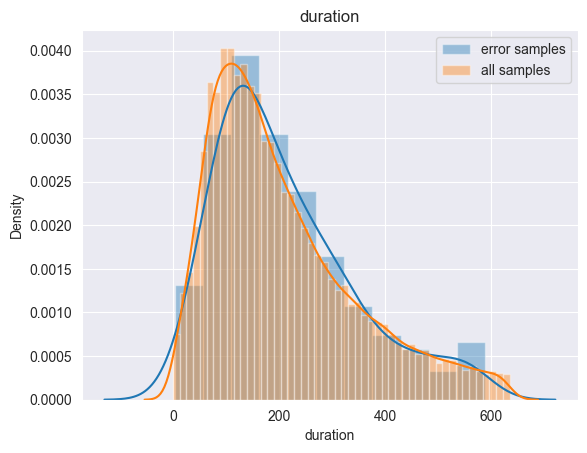

C:\Users\jessi\AppData\Local\Temp\ipykernel_58076\3075011763.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(common_errors[col], label='error samples')
C:\Users\jessi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2517: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\jessi\AppData\Local\Temp\ipykernel_58076\3075011763.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn

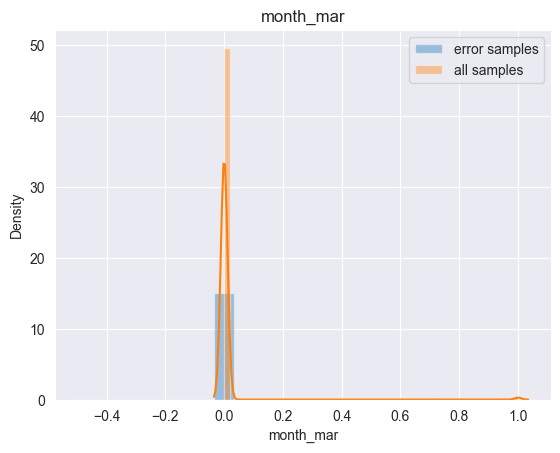

C:\Users\jessi\AppData\Local\Temp\ipykernel_58076\3075011763.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(common_errors[col], label='error samples')
C:\Users\jessi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2517: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\jessi\AppData\Local\Temp\ipykernel_58076\3075011763.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn

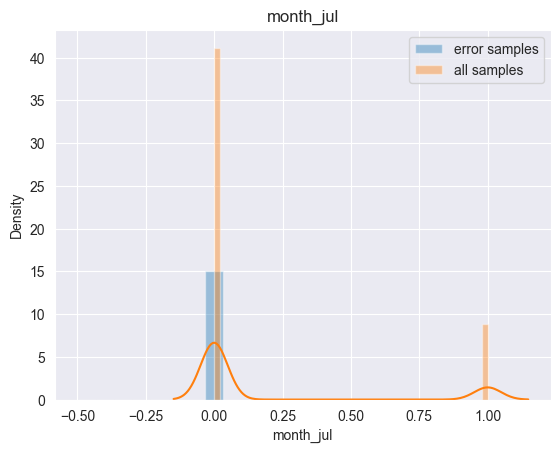

C:\Users\jessi\AppData\Local\Temp\ipykernel_58076\3075011763.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(common_errors[col], label='error samples')
C:\Users\jessi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2517: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\jessi\AppData\Local\Temp\ipykernel_58076\3075011763.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn

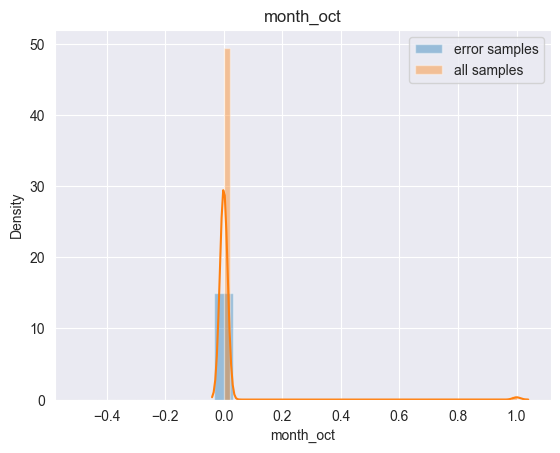

C:\Users\jessi\AppData\Local\Temp\ipykernel_58076\3075011763.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(common_errors[col], label='error samples')
C:\Users\jessi\AppData\Local\Temp\ipykernel_58076\3075011763.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label='all samples

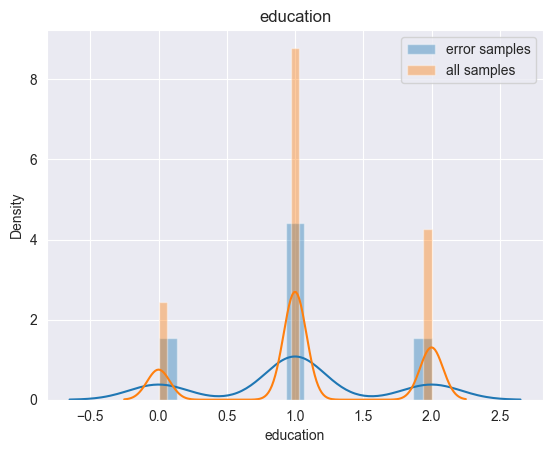

In [143]:
# plot the distribution of wrong samples in important features
important_features = ['duration', 'month_mar', 'month_jul', 'month_oct', 'education']
for col in important_features:
    plt.figure()
    sns.distplot(common_errors[col], label='error samples')
    sns.distplot(df[col], label='all samples')
    plt.legend()
    plt.title(col)
    plt.show()

From several descriptive statistics and graph, we can see that no significant differences in found between regular sample and error sample. Thus, one possible explanation is that these samples do not have significant feature values and are more "averaged", which makes model hard to correlate their feature values to a certain class.

### Conclusion
- in this project, I used the Bank Marketing dataset from Kaggle to train classification models to predict marketing success (if customer will subscribe or not). Specifically, I trained Logistic Regression, Random Forests and XGBoost. All models performed above 80% accuracy, however, they all performed not so well on predicting the positive class (subscribed), with F1 score around 0.3.This suggests data imbalance probelm. Even after using methods like undersampling and oversampling, the F1 score is not significantly improved. Out of the three models, XGBoost performs the best across all metrics but also took longest time to run. 
- In summary of all models, I found the most important features are duration of last contact, month of last contact and education. These makes sense because they are indicative of past contact with the client, which suggests good customer relationship, thus they are more likely to enroll in the new program.